In [1]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
from scipy.interpolate import spline
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
keras.__version__

'1.2.2'

In [3]:
tensorflow.__version__

'0.12.0'

In [4]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

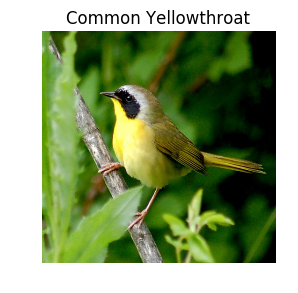

In [5]:
img = load_img('data/train/common_yellowthroat/Common_Yellowthroat_0004_272622598.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Common Yellowthroat')
plt.show()

In [6]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

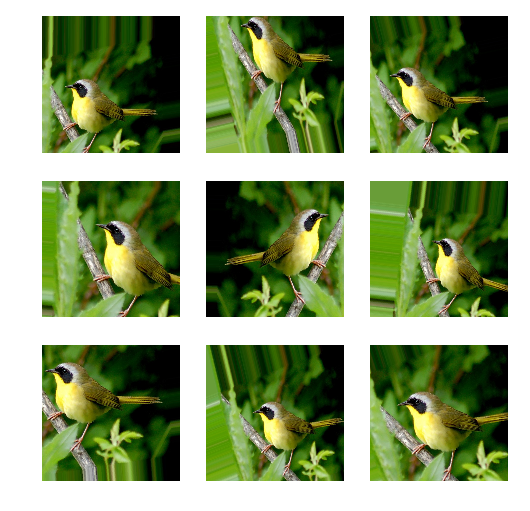

In [7]:
i = 0
fig = plt.figure(figsize = (6,6))
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

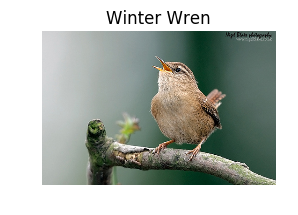

In [8]:
img = load_img('data/train/winter_wren/Winter_Wren_0025_2703419796.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Winter Wren')
plt.show()

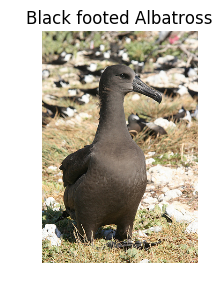

In [9]:
img = load_img('data/train/Black_footed_Albatross/Black_footed_Albatross_0002_2293084168.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Black footed Albatross')
plt.show()

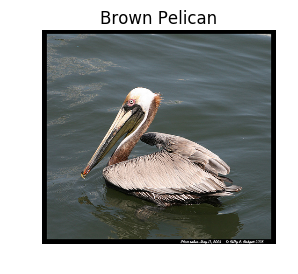

In [10]:
img = load_img('data/train/Brown_Pelican/Brown_Pelican_0031_2485662146.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Brown Pelican')
plt.show()

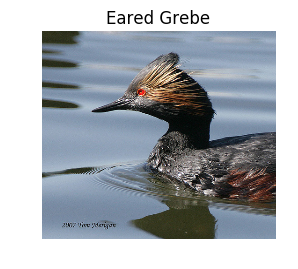

In [11]:
img = load_img('data/train/Eared_Grebe/Eared_Grebe_0024_1876616311.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Eared Grebe')
plt.show()

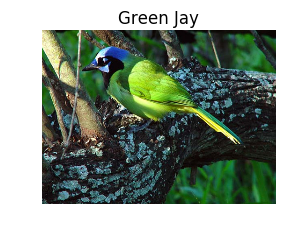

In [12]:
img = load_img('data/train/Green_Jay/Green_Jay_0033_390572264.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Green Jay')
plt.show()

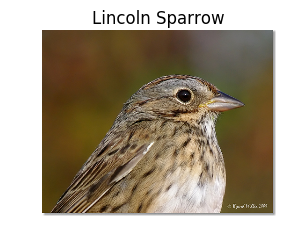

In [13]:
img = load_img('data/train/Lincoln_Sparrow/Lincoln_Sparrow_0023_2887691144.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Lincoln Sparrow')
plt.show()

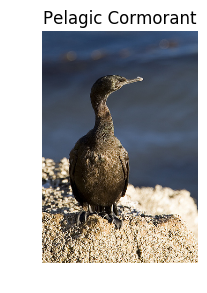

In [14]:
img = load_img('data/train/Pelagic_Cormorant/Pelagic_Cormorant_0028_327884826.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Pelagic Cormorant')
plt.show()

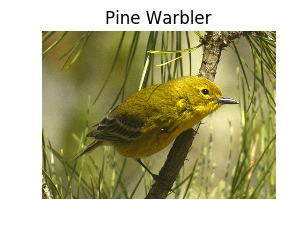

In [15]:
img = load_img('data/train/Pine_Warbler/Pine_Warbler_0022_2979156099.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Pine Warbler')
plt.show()

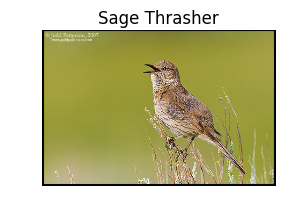

In [16]:
img = load_img('data/train/Sage_Thrasher/Sage_Thrasher_0003_745274894.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Sage Thrasher')
plt.show()

In [17]:
# default settings
img_width, img_height = 224, 224

train_dir = 'data/train'
validate_dir = 'data/validate'
nb_epochs = 20
batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

In [18]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

264


In [19]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

206


In [20]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [21]:
# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [22]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 264 images belonging to 10 classes.


In [23]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 206 images belonging to 10 classes.


In [24]:
# set up transfer learning on pre-trained ImageNet VGG19 model - remove fully connected layer and replace
# with softmax for classifying 10 classes
vgg19_model = VGG19(weights = 'imagenet', include_top = False)
x = vgg19_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(input = vgg19_model.input, output = predictions)

In [25]:
# freeze all layers of the pre-trained model
for layer in vgg19_model.layers:
    layer.trainable = False

In [26]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [27]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
264/264 [==============================] - 274s - loss: 2.5164 - acc: 0.1667 - val_loss: 2.4119 - val_acc: 0.1602
Epoch 2/20
264/264 [==============================] - 274s - loss: 2.2026 - acc: 0.2121 - val_loss: 2.1199 - val_acc: 0.2427
Epoch 3/20
264/264 [==============================] - 273s - loss: 2.0347 - acc: 0.2538 - val_loss: 1.9245 - val_acc: 0.3932
Epoch 4/20
264/264 [==============================] - 271s - loss: 1.9516 - acc: 0.3144 - val_loss: 1.8520 - val_acc: 0.3301
Epoch 5/20
264/264 [==============================] - 273s - loss: 1.8186 - acc: 0.3826 - val_loss: 1.9118 - val_acc: 0.3204
Epoch 6/20
264/264 [==============================] - 273s - loss: 1.7769 - acc: 0.3826 - val_loss: 1.7496 - val_acc: 0.4029
Epoch 7/20
264/264 [==============================] - 272s - loss: 1.6617 - acc: 0.4205 - val_loss: 1.9055 - val_acc: 0.3252
Epoch 8/20
264/264 [==============================] - 272s - loss: 1.6506 - acc: 0.4508 - val_loss: 2.1804 - val_acc: 0.1942


In [28]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 1.32174146175
Test Accuracy: 0.5


In [29]:
# save transfer learning model for offline prediction purposes
model.save('birds_vgg19_model_tl.h5')

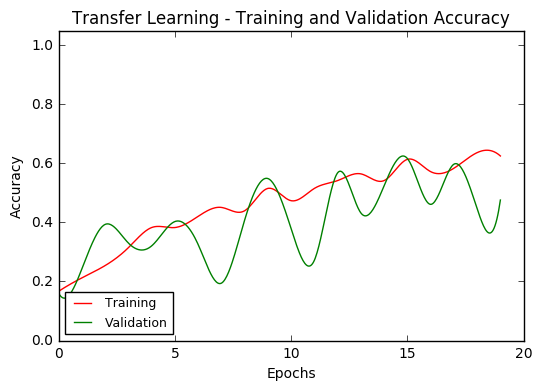

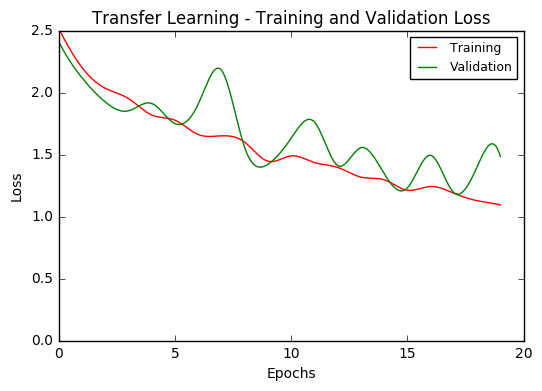

In [30]:
xfer_acc = transfer_learning_history.history['acc']
val_acc = transfer_learning_history.history['val_acc']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.05)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 500)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2.5)
plt.show()

In [31]:
validate_generator.total_batches_seen

351

In [32]:
num_images = len(glob.glob("birds_test/*.jpg"))

In [33]:
predict_files = glob.glob("birds_test/*.jpg")

In [34]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [35]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

In [36]:
final = pd.DataFrame()
final["id"] = image_id
final["Bird"] = predictor
final.head(num_images)

,id,Bird
0,Black_footed_Albatross_0009_2408326989.jpg,0
1,Black_footed_Albatross_0010_819241733.jpg,0
2,Black_footed_Albatross_0033_2472109427.jpg,0
3,Brown_Pelican_0001_300645975.jpg,1
4,Brown_Pelican_0011_2726168437.jpg,1
5,Brown_Pelican_0021_528648372.jpg,1
6,Common_Yellowthroat_0002_2679007659.jpg,5
7,Common_Yellowthroat_0003_2278933940.jpg,4
8,Eared_Grebe_0016_2453881646.jpg,0
9,Eared_Grebe_0021_407547377.jpg,3


In [37]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [38]:
final["Bird"] = final["Bird"].apply(lambda x: classes[x])
final.head(num_images)

,id,Bird
0,Black_footed_Albatross_0009_2408326989.jpg,Black_footed_Albatross
1,Black_footed_Albatross_0010_819241733.jpg,Black_footed_Albatross
2,Black_footed_Albatross_0033_2472109427.jpg,Black_footed_Albatross
3,Brown_Pelican_0001_300645975.jpg,Brown_Pelican
4,Brown_Pelican_0011_2726168437.jpg,Brown_Pelican
5,Brown_Pelican_0021_528648372.jpg,Brown_Pelican
6,Common_Yellowthroat_0002_2679007659.jpg,Lincoln_Sparrow
7,Common_Yellowthroat_0003_2278933940.jpg,Green_Jay
8,Eared_Grebe_0016_2453881646.jpg,Black_footed_Albatross
9,Eared_Grebe_0021_407547377.jpg,Eared_Grebe


In [39]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 globalaveragepooling2d_1
23 dense_1
24 dense_2


In [40]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, None, None, 64 1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, None, None, 64 36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, None, None, 64 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [41]:
# Step 1 - Set up fine tuning on pre-trained ImageNet vgg19 model - train all layers
for layer in model.layers:
    layer.trainable = True
    
# Step 2 - Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9
model.compile(optimizer = SGD(lr = 0.0001, momentum=0.9), 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# Step 3 - Fit the revised model, log the results and the training time
now = datetime.datetime.now
t = now()
fine_tuning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
264/264 [==============================] - 558s - loss: 1.1804 - acc: 0.5833 - val_loss: 0.9941 - val_acc: 0.6699
Epoch 2/20
264/264 [==============================] - 553s - loss: 0.8391 - acc: 0.7083 - val_loss: 0.8900 - val_acc: 0.7233
Epoch 3/20
264/264 [==============================] - 553s - loss: 0.6721 - acc: 0.8144 - val_loss: 0.8433 - val_acc: 0.7282
Epoch 4/20
264/264 [==============================] - 554s - loss: 0.6242 - acc: 0.7992 - val_loss: 0.8753 - val_acc: 0.7136
Epoch 5/20
264/264 [==============================] - 552s - loss: 0.5632 - acc: 0.7992 - val_loss: 0.7210 - val_acc: 0.7670
Epoch 6/20
264/264 [==============================] - 553s - loss: 0.5039 - acc: 0.8144 - val_loss: 0.7196 - val_acc: 0.7573
Epoch 7/20
264/264 [==============================] - 553s - loss: 0.4796 - acc: 0.8295 - val_loss: 0.7266 - val_acc: 0.7330
Epoch 8/20
264/264 [==============================] - 554s - loss: 0.4290 - acc: 0.8712 - val_loss: 0.5721 - val_acc: 0.8155


In [42]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.586144208908
Test Accuracy: 0.75


In [43]:
# save fine-tuning model for offline prediction purposes
model.save('birds_vgg19_model_ft.h5')

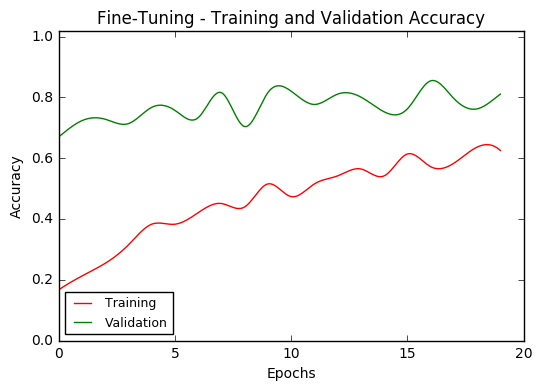

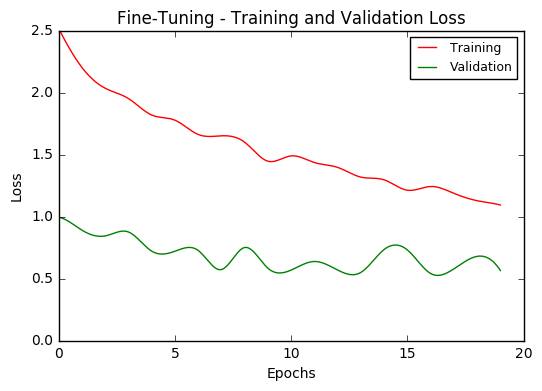

In [44]:
ft_acc = fine_tuning_history.history['acc']
val_acc = fine_tuning_history.history['val_acc']
ft_loss = fine_tuning_history.history['loss']
val_loss = fine_tuning_history.history['val_loss']
epochs = range(len(ft_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Fine-Tuning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.02)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Fine-Tuning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 2.5)
plt.show()

In [45]:
validate_generator.total_batches_seen

702

In [46]:
# predict unseen images
predict_files = glob.glob("birds_test/*.jpg")

In [47]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [48]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

In [49]:
final = pd.DataFrame()
final["id"] = image_id
final["Bird"] = predictor 
final.head(num_images)

,id,Bird
0,Black_footed_Albatross_0009_2408326989.jpg,0
1,Black_footed_Albatross_0010_819241733.jpg,0
2,Black_footed_Albatross_0033_2472109427.jpg,4
3,Brown_Pelican_0001_300645975.jpg,1
4,Brown_Pelican_0011_2726168437.jpg,1
5,Brown_Pelican_0021_528648372.jpg,1
6,Common_Yellowthroat_0002_2679007659.jpg,7
7,Common_Yellowthroat_0003_2278933940.jpg,4
8,Eared_Grebe_0016_2453881646.jpg,4
9,Eared_Grebe_0021_407547377.jpg,3


In [50]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [51]:
final["Bird"] = final["Bird"].apply(lambda x: classes[x])
final.head(num_images)

,id,Bird
0,Black_footed_Albatross_0009_2408326989.jpg,Black_footed_Albatross
1,Black_footed_Albatross_0010_819241733.jpg,Black_footed_Albatross
2,Black_footed_Albatross_0033_2472109427.jpg,Green_Jay
3,Brown_Pelican_0001_300645975.jpg,Brown_Pelican
4,Brown_Pelican_0011_2726168437.jpg,Brown_Pelican
5,Brown_Pelican_0021_528648372.jpg,Brown_Pelican
6,Common_Yellowthroat_0002_2679007659.jpg,Pine_Warbler
7,Common_Yellowthroat_0003_2278933940.jpg,Green_Jay
8,Eared_Grebe_0016_2453881646.jpg,Green_Jay
9,Eared_Grebe_0021_407547377.jpg,Eared_Grebe
